In [1]:
%load_ext autoreload
%autoreload 2
import os
import time
import pickle
import numpy as np
import multiprocessing as mp
from IPython.display import SVG

from pydrake.geometry import MeshcatVisualizer, MeshcatVisualizerParams, Role, StartMeshcat
from pydrake.geometry.optimization import IrisInConfigurationSpace, IrisOptions
from pydrake.multibody.parsing import LoadModelDirectives, Parser, ProcessModelDirectives
from pydrake.multibody.plant import AddMultibodyPlantSceneGraph
from pydrake.solvers import MosekSolver
from pydrake.systems.framework import DiagramBuilder

from gcs.linear import LinearGCS
from gcs.rounding import randomForwardPathSearch
from reproduction.prm_comparison.helpers import (
    get_traj_length,
    InverseKinematics,
    make_traj,
    visualize_trajectory
)

from reproduction.util import GcsDir, FindModelFile

mosek_license = MosekSolver.AcquireLicense()

In [2]:
# Start the visualizer (run this cell only once, each instance consumes a port)
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7000


In [3]:
SEED = 0
np.random.seed(SEED)
CORE_CNT = mp.cpu_count() # you may edit this.

In [4]:
meshcat.Delete()
builder = DiagramBuilder()
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
parser = Parser(plant)
parser.package_map().Add("gcs", GcsDir())

directives_file = FindModelFile("models/iiwa14_welded_gripper.yaml")
directives = LoadModelDirectives(directives_file)
models = ProcessModelDirectives(directives, plant, parser)
[iiwa, wsg, shelf, binR, binL, table] = models
iiwa_idx = plant.GetModelInstanceByName("iiwa")
wsg_idx = plant.GetModelInstanceByName("wsg")

plant.Finalize()

meshcat_params = MeshcatVisualizerParams()
meshcat_params.delete_on_initialization_event = False
meshcat_params.role = Role.kIllustration
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat,
                                             meshcat_params)

diagram = builder.Build()

context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
plant.SetPositions(plant_context, q0)
diagram.ForcedPublish(context)

## IRIS Seeds

In [8]:
milestones = {
    "AS": [[0.75, 0, 0.9], [0, -np.pi, -np.pi / 2]],
    "TS": [[0.75, 0, 0.67], [0, -np.pi, -np.pi / 2]],
    "CS": [[0.75, 0, 0.41], [0, -np.pi, -np.pi / 2]],
    "LB": [[0.0, 0.6, 0.22], [np.pi / 2, np.pi, 0]],
    "RB": [[0.0, -0.6, 0.22], [np.pi / 2, np.pi, np.pi]]
}

additional_seed_points = {
    "C": np.array([0, 0.2, 0, -2.09, 0, -0.3, np.pi / 2]),
    "L": np.array([0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2]),
    "R": np.array([-0.8, 0.7, 0, -1.6, 0, 0, np.pi / 2])
}

q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
milestone_configurations = {
    name: InverseKinematics(q0, trans, rot)
    for name, (trans, rot) in milestones.items()
}

seed_points = {**milestone_configurations, **additional_seed_points}

# Load pre-generated regions

In [ ]:
#load regions
with open(os.path.join(GcsDir(), "data/prm_comparison/IRIS.reg"), "rb") as f:
    regions = pickle.load(f)

In [5]:
from pydrake.geometry.optimization import LoadIrisRegionsYamlFile
regions = LoadIrisRegionsYamlFile("/home/lhc/IRIS1.reg")

# Or Regenerate IRIS Regions

Note: This IRIS region computation is slow. We give the option to load the pre-generated regions in the cells below; in which case you can skip this step.

## via manual seeds

In [9]:
iris_options = IrisOptions()
iris_options.require_sample_point_is_contained = True
iris_options.iteration_limit = 10
iris_options.termination_threshold = -1
iris_options.relative_termination_threshold = 0.02
iris_options.num_collision_infeasible_samples = 1
iris_options.random_seed = SEED


In [10]:
def calcRegion(seed, verbose):
    start_time = time.time()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyContextFromRoot(context)
    plant.SetPositions(plant_context, seed)
    try:
        hpoly = IrisInConfigurationSpace(plant, plant_context, iris_options)
    except Exception as e:
        print(f"Seed: {seed} failed with error: {e}")
        return None
    if verbose:
        print("Seed:", seed, "\tTime:", time.time() - start_time, flush=True)
    return hpoly


def generateRegions(seed_points, verbose=True):
    seeds = list(
        seed_points.values()) if type(seed_points) is dict else seed_points
    regions = []
    loop_time = time.time()
    with mp.Pool(processes=min(CORE_CNT, len(seed_points))) as pool:
        regions = pool.starmap(calcRegion, [[seed, verbose] for seed in seeds])

    if verbose:
        print("Loop time:", time.time() - loop_time)

    if type(seed_points) is dict:
        return dict(list(zip(seed_points.keys(), regions)))

    return regions

In [11]:
regions = generateRegions(seed_points)

INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake:IrisInConfigurationSpace iteration 0
INFO:drake: Checking wsg::collision against binR::bottom has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binR::bottom after 10 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 15 counter-example searches.
INFO:drake: Checking wsg::collision against table::table_top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking ws

Seed: [ 1.33265646  0.78659304  0.36234515 -1.49165536 -0.3192406   0.92172586
  1.79117655] 	Time: 731.8657891750336


INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake: Checking iiwa::Sphere against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves::top after 23 counter-example searches.
INFO:drake:IrisInConfigurationSpace: terminating iterations because the seed point is no longer in the region.


Seed: [ 6.47954345e-05  4.71948686e-01 -1.50228796e-04 -6.71688380e-01
  1.84572357e-04  4.26144408e-01  1.57069334e+00] 	Time: 743.5247755050659


INFO:drake: Checking wsg::collision against binR::front has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binR::front after 13 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake: Checking wsg::collision against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 17 counter-example searches.
INFO:drake: Checking wsg::collision against binL::right has already required 10 counter-example searches; still searching...
INFO:drake:IrisInConfigurationSpace iteration 1
INFO:drake: Finished checking wsg::collision against binL::right after 13 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::left_wall has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision ag

Seed: [ 0.8         0.7         0.         -1.6         0.          0.
  1.57079633] 	Time: 1362.8637220859528


INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking wsg::collision against binR::right has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binR::right after 10 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking wsg::collision against shelves::shelf_lower has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::shelf_lower after 10 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 2
INFO:drake: Checking wsg::collision against binR::bottom has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against binR::bottom after 14 counter-example searches.
INFO:drake: Checking wsg::collision against binR::bottom has already required 10 counter-example searches; still 

Seed: [-1.33245325  0.78664735 -0.36266282 -1.4916558   0.31952413  0.92177573
  1.3502225 ] 	Time: 1537.5233075618744


INFO:drake: Checking iiwa::Sphere against shelves::shelf_upper has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves::shelf_upper after 12 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 3
INFO:drake: Checking iiwa::Sphere against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves::top after 11 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 24 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::shelf_upper has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::shelf_upper after 10 counter-example searches.
INFO:drake: Checking

Seed: [-0.8         0.7         0.         -1.6         0.          0.
  1.57079633] 	Time: 2319.331606388092


INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake:IrisInConfigurationSpace iteration 4
INFO:drake: Checking iiwa::Sphere against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves::top after 15 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 15 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::shelf_upper has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::shelf_upper after 12 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 10 counter-ex

Seed: [ 0.          0.2         0.         -2.09        0.         -0.3
  1.57079633] 	Time: 3170.3417477607727


INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake: Checking wsg::collision against shelves::shelf_upper has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::shelf_upper after 22 counter-example searches.
INFO:drake:IrisInConfigurationSpace iteration 5
INFO:drake: Checking iiwa::Sphere against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking iiwa::Sphere against shelves::top after 14 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::top has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::top after 27 counter-example searches.
INFO:drake: Checking wsg::collision against shelves::shelf_upper has already required 10 counter-example searches; still searching...
INFO:drake: Finished checking wsg::collision against shelves::shelf_upper aft

Seed: [-1.53002399e-04  3.97271237e-01  2.17071414e-04 -1.36747012e+00
  2.49732016e-04 -1.92930145e-01  1.57046699e+00] 	Time: 4862.77561378479


INFO:drake:IrisInConfigurationSpace: Terminating because the hyperellipsoid relative volume change 0.009181422333170522 is below the threshold 0.02.


Seed: [-1.75985292e-04  6.83023176e-01  2.45005155e-04 -1.64782205e+00
  2.09490491e-05 -7.59033997e-01  1.57062626e+00] 	Time: 5483.28369474411
Loop time: 5483.345020532608


# Create the GCS Trajectory Optimization

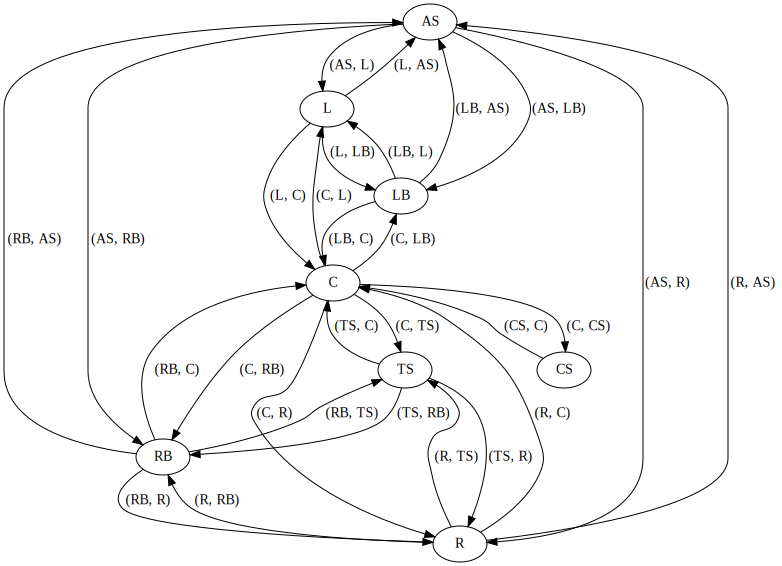

In [6]:
gcs = LinearGCS(regions)
SVG(gcs.VisualizeGraph()) 

# Run Comparison

In [7]:
solver_tolerance = 1e-3


def getGCSPath(sequence, verbose=False):
    path = [sequence[0]]
    run_time = 0.0
    for start_pt, goal_pt in zip(sequence[:-1], sequence[1:]):
        gcs = LinearGCS(regions)
        gcs.addSourceTarget(start_pt, goal_pt)
        gcs.setRoundingStrategy(randomForwardPathSearch,
                                max_paths=10,
                                max_trials=100,
                                seed=SEED)
        gcs.setSolver(MosekSolver())
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_PFEAS',
                                             solver_tolerance)
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_DFEAS',
                                             solver_tolerance)
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_REL_GAP',
                                             solver_tolerance)
        gcs.options.solver_options.SetOption(MosekSolver.id(),
                                             'MSK_DPAR_INTPNT_TOL_INFEAS',
                                             solver_tolerance)
        waypoints, results_dict = gcs.SolvePath(rounding=True,
                                                verbose=False,
                                                preprocessing=True)
        if waypoints is None:
            if verbose:
                print(f"Failed between {start_pt} and {goal_pt}")
            return None

        run_time += results_dict["relaxation_solver_time"]
        run_time += results_dict[
            "max_rounded_solver_time"]  # only take the max since rounding can be parallelized
        if verbose:
            print(
                "Convex Relaxation", round(results_dict["relaxation_cost"],
                                           3), "min hard result cost",
                round(results_dict["rounded_cost"], 3), "Gap",
                round((results_dict["rounded_cost"] -
                       results_dict["relaxation_cost"]) /
                      results_dict["relaxation_cost"], 3))

        path += waypoints.T[1:].tolist()
    return np.stack(path).T, run_time

## Demonstration

In [8]:
demonstration = {
    "AS": [[0.75, -0.12, 0.9], [0, -np.pi, -np.pi / 2]],
    "TS": [[0.75, 0.12, 0.67], [0, -np.pi, -np.pi / 2]],
    "CS": [[0.75, 0.12, 0.41], [0, -np.pi, -np.pi / 2]],
    "LB": [[0.08, 0.6, 0.22], [np.pi / 2, np.pi, 0]],
    "RB": [[-0.08, -0.6, 0.22], [np.pi / 2, np.pi, np.pi]]
}

q0 = [0, 0.3, 0, -1.8, 0, 1, 1.57]
demonstration_configurations = {
    name: InverseKinematics(q0, trans, rot)
    for name, (trans, rot) in demonstration.items()
}

In [9]:
task_1 = [demonstration_configurations["AS"],
          demonstration_configurations["TS"]]

task_2 = [demonstration_configurations["TS"],
          demonstration_configurations["CS"]]

task_3 = [demonstration_configurations["CS"],
          demonstration_configurations["LB"]]

task_4 = [demonstration_configurations["LB"],
          demonstration_configurations["RB"]]

task_5 = [demonstration_configurations["RB"],
          demonstration_configurations["AS"]]

task_circle = [demonstration_configurations["AS"],
               demonstration_configurations["TS"],
               demonstration_configurations["CS"],
               demonstration_configurations["LB"],
               demonstration_configurations["RB"],
               demonstration_configurations["AS"]]

In [16]:
execute_task = task_2
GCS_path, GCS_time = getGCSPath(execute_task, verbose=True)
linear_gcs_traj = make_traj(GCS_path, speed=2)
print(
    f"Linear GCS length: {round(get_traj_length(linear_gcs_traj), 3)}, and time: {round(GCS_time, 3)} s"
)


INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=true and no rounding.
INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=false and no rounding.
INFO:drake:Solved GCS shortest path using MOSEK with convex_relaxation=true and preprocessing=false and no rounding.


Convex Relaxation 2.149 min hard result cost 2.151 Gap 0.001
Linear GCS length: 2.151, and time: 0.094 s


In [18]:
from pydrake.geometry.optimization import SaveIrisRegionsYamlFile
SaveIrisRegionsYamlFile("/home/lhc/IRIS1.reg",regions)

In [17]:
from reproduction.prm_comparison.helpers import (
    get_traj_length,
    InverseKinematics,
    make_traj,
    visualize_trajectory
)
visualize_trajectory(meshcat, [linear_gcs_traj],
                     show_path=True,
                     robot_configurations=execute_task,
                     transparency=0.3)


In [ ]:
with open ("GCS_PRM10k_comparison.html", "w") as f:
    f.write(meshcat.StaticHtml())